In [10]:
import math
from enum import Enum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from mpl_toolkits.axes_grid1 import make_axes_locatable

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


class CitizenState(Enum):
    ACTIVE = 1    
    QUIET = 2    
    ARRESTED = 3

def count(model, state):
    """Counts the number of citizens with the user-defined state"""
    count = 0
    for agent in model.schedule.agents:
        if isinstance(agent, Cop):
            continue
        else:
            if agent.state == state:
                count += 1
    return count

class CivilViolence(Model):
    """Model class for Eppstein's Civil Violence model I.
    
    The initial values are from Eppstein's article.
    """

    def __init__(self, height=40, width=40, citizen_density=0.7, citizen_vision=7,
        legitimacy=0.82, activation_treshold=0.1, arrest_prob_constant=2.3,
        cop_density=0.04, cop_vision=7, max_jail_term=15, seed=None):
        super().__init__(seed=seed)

        assert (citizen_density+cop_density) < 1
        
        # setup Citizen class attributes
        Citizen.vision = citizen_vision
        Citizen.legitimacy = legitimacy
        Citizen.arrest_prob_constant = arrest_prob_constant
        Citizen.activation_threshold = activation_treshold
        
        # setup Cop class attributes
        Cop.vision = cop_vision
        Cop.max_jail_term = max_jail_term

        # setup data collection
        model_reporters = {'active': lambda m: count(m, CitizenState.ACTIVE),
                           'quiet': lambda m: count(m, CitizenState.QUIET),
                           'arrested': lambda m: count(m, CitizenState.ARRESTED)}
       
        self.datacollector = DataCollector(model_reporters=model_reporters)
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)

        # Set up agents
        id = 1
        for i,x,y in self.grid.coord_iter():
            klass = random.choices([Citizen, Cop, None], cum_weights = [citizen_density, 
                                                                        cop_density+citizen_density, 
                                                                         1])[0]
            if klass != None:
                agent = klass(id, self)
                id += 1
                self.grid.position_agent(agent, (x,y))
                self.schedule.add(agent)
                
    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)


class BaseAgent(Agent):
    '''Base Agent class implementing vision and moving
    
    Attributes
    ----------
    moore : boolean
    
    '''    
    moore = False
    
    def get_agents_in_vision(self):
        """
        identify cops and active citizens within vision
        
        Returns
        -------
        tuple with list of cops, and list of active citizens
        
        """
        cops = []
        active_citizens = []
        
        for cell in self.model.grid.get_neighbors(self.pos,
                         moore=BaseAgent.moore, radius=self.__class__.vision):
            if isinstance(cell, Cop):
                cops.append(cell)
            elif cell.state == CitizenState.ACTIVE:
                active_citizens.append(cell)    
        return cops, active_citizens
    
    def move(self):
        """
        identify all empty cells within vision and move
        to a randomly selected one.
        """
        empty = []
        for pos in self.model.grid.get_neighborhood(self.pos,
                        moore=BaseAgent.moore, radius=self.__class__.vision):        
            if self.model.grid.is_cell_empty(pos):
                empty.append(pos)
        
        if empty:
            new_pos = self.random.choice(empty)
            self.model.grid.move_agent(self, new_pos)
        
    
class Citizen(BaseAgent):
    '''Citizen class
    
    Attributes
    ----------
    legitimacy : boolean
    vision : int
    arrest_prob_constant : float
    activation_treshold : float
    hardship : float
    risk_aversion : float
    state : {CitizenState.QUIET, CitizenState.ACTIVE, CitizenState.ARRESTED }
    jail_time_remaining  :int
    grievance : float
    
    '''        
    legitimacy = 1
    vision = 1
    arrest_prob_constant = 1
    activation_treshold = 1
    
    def __init__(self, identity, model):
        super().__init__(identity, model)
        self.hardship = self.random.random()
        self.risk_aversion = self.random.random()
        self.state = CitizenState.QUIET
        self.jail_time_remaining = 0
        self.grievance = self.hardship*(1-Citizen.legitimacy)
        
    def _check_jail_time(self):
        if (self.state == CitizenState.ARRESTED) and (self.jail_time_remaining > 0):
            self.jail_time_remaining -= 1
        return self.jail_time_remaining

    def step(self):
        """
        move and then decide whether to activate
        """
        
        if self._check_jail_time() > 0:
            return
            
        self.move()
            
        cops, active_citizens = self.get_agents_in_vision()
        n_cops = len(cops)
        n_active_citizens = len(active_citizens) + 1 # self is always considerd active
            
        arrest_p = 1 - math.exp(-1*Citizen.arrest_prob_constant * (n_cops/n_active_citizens))
        net_risk = self.risk_aversion * arrest_p
        
        if (self.grievance - net_risk) > self.activation_threshold:
            self.state = CitizenState.ACTIVE
        else:
            self.state = CitizenState.QUIET
        

class Cop(BaseAgent):
    '''Cop class
    
    Attributes
    ----------
    vision : int
    max_jail_term : int
    '''
    vision = 1
    max_jail_term = 1
        
    def step(self):
        self.move()
        cops, active_citizens = self.get_agents_in_vision()
        
        if active_citizens:
            citizen = self.random.choice(active_citizens)
            citizen.state = CitizenState.ARRESTED
            citizen.jail_time_remaining = self.random.randint(0, 
                                                              Cop.max_jail_term)

            
def visualize_model(model):
    sns.set_style('white')
    colors = sns.color_palette()[0:4]
    
    # if the plot is not nice given your window size
    # consider changing figsize, but keep the ratio intact
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 20))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    positions = []
    color_type = []
    grievance_level = []
    
    for i, (cell, x,y) in enumerate(model.grid.coord_iter()):
        if not cell:
            continue
        
        positions.append([x,y])
        if isinstance(cell, Citizen):
            color_type.append(colors[cell.state.value])
            grievance_level.append(cell.grievance)
        else:
            color_type.append(colors[0])
            grievance_level.append(np.NaN) #dirty hack for masking
    
    positions = np.asarray(positions)
    
    ax1.scatter(positions[:, 0], positions[:, 1], s=15, c=color_type)
    im = ax2.scatter(positions[:, 0], positions[:, 1], s=15, c=grievance_level)
    
    for ax in (ax1, ax2):
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax1.set_title('Agent states')
    ax2.set_title('grievance view')

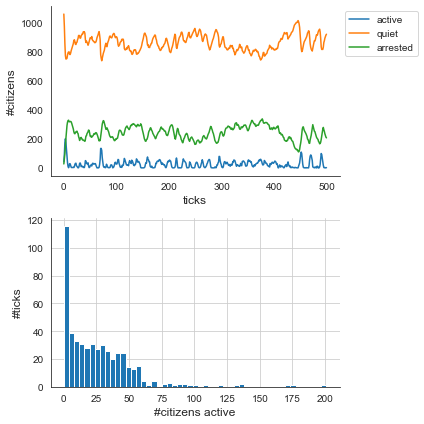

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6))

data = model.datacollector.get_model_vars_dataframe()
data.plot(ax=ax1)
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_xlabel('ticks', fontsize=12)
ax1.set_ylabel('#citizens', fontsize=12)

data.active.hist(bins=51, ax=ax2)
ax2.set_xlabel('#citizens active', fontsize=12)
ax2.set_ylabel('#ticks', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [15]:
from mesa.batchrunner import batch_run
        
params = {'height': 40, 'width': 40,
          'citizen_density': 0.7,'citizen_vision': 7,
          'legitimacy': 0.82, 'activation_treshold':0.1,
         'arrest_prob_constant': 2.3, 'cop_density':0.04,
         'cop_vision': 7, 'max_jail_term': [5,15,30]}

results = batch_run(
    CivilViolence,
    params,
    iterations=5,
    max_steps=50
)

100%|██████████| 15/15 [01:03<00:00,  4.24s/it]


In [16]:
results_df = pd.DataFrame(results)
results_df.head(50)

,RunId,iteration,Step,height,width,citizen_density,citizen_vision,legitimacy,activation_treshold,arrest_prob_constant,cop_density,cop_vision,max_jail_term,active,quiet,arrested
0,0,0,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,5,10,1098,28
1,1,0,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,15,2,1096,24
2,2,0,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,30,2,1056,90
3,3,1,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,5,1,1102,36
4,4,1,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,15,7,1079,96
5,5,1,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,30,11,1045,76
6,6,2,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,5,3,1075,25
7,7,2,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,15,10,1042,56
8,8,2,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,30,0,1046,45
9,9,3,50,40,40,0.7,7,0.82,0.1,2.3,0.04,7,5,6,1097,17


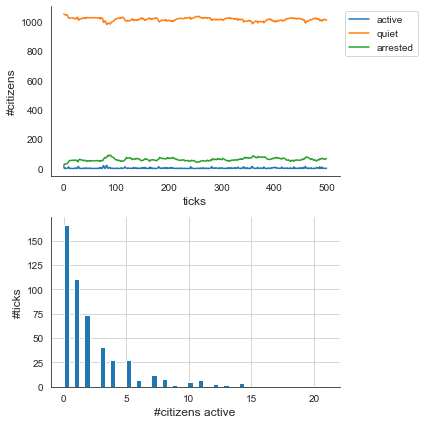

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6))

data = model.datacollector.get_model_vars_dataframe()
data.plot(ax=ax1)
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_xlabel('ticks', fontsize=12)
ax1.set_ylabel('#citizens', fontsize=12)

data.active.hist(bins=51, ax=ax2)
ax2.set_xlabel('#citizens active', fontsize=12)
ax2.set_ylabel('#ticks', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

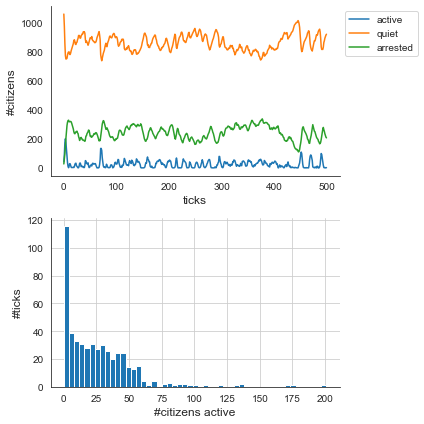